In [1]:
import psycopg2
from sqlalchemy import create_engine, Column, Integer, String, Float, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker

In [2]:
Base = declarative_base()

In [3]:
class Recipe(Base):
    __tablename__ = 'recipes'
    
    id = Column(Integer, primary_key=True)
    name = Column(String)
    url = Column(String, unique=True)
    calories = Column(Integer)
    fat = Column(Float)
    carbs = Column(Float)
    protein = Column(Float)
    cholesterol = Column(Float)
    sodium = Column(Float)
    servings = Column(Integer)
    #ingredients = 
    #__table_args__ = {'extend_existing': True}
    
    def __repr__(self):
        return "<Recipe(name='%s', url='%s')>" % (
            self.name, self.url)
    
class Ingredient(Base):
    __tablename__ = 'ingredients'
    id = Column(Integer, primary_key = True)
    ingredient = Column(String, nullable = False)
    recipe_id = Column(Integer, ForeignKey('recipes.id'))
    
    recipe = relationship(Recipe, back_populates = 'ingredients')
    #__table_args__ = {'extend_existing': True}
    def __repr__(self):
        return "<Ingredient(ingredient='%s')>" % self.ingredient

Recipe.ingredients = relationship("Ingredient", order_by=Ingredient.id, back_populates="recipe")

class Restaurant(Base):
    __tablename__ = 'restaurants'
    id = Column(Integer, primary_key=True)
    name = Column(String)
    url = Column(String)
    zomatoID = Column(Integer, unique=True)
    costfortwo = Column(Float)
    featured_image = Column(String)
    photos = Column(String)
    menu_url = Column(String)
    price_range = Column(Integer)
    latitude = Column(Float)
    longitude = Column(Float)
    address = Column(String)
    
    def __repr__(self):
        return "<Restaurant(name='%s', url='%s')>" % (
            self.name, self.url)

class MenuItem(Base):
    __tablename__ = 'menuitems'
    id = Column(Integer, primary_key=True)
    menuitem = Column(String, nullable = False)
    description = Column(String)
    restaurant_id = Column(Integer, ForeignKey('restaurants.id'))
    price = Column(String)
    
    restaurant = relationship(Restaurant, back_populates = 'menuitems')
    __table_args__ = {'extend_existing': True}
    def __repr__(self):
        return "<Restaurant(name='%s', url='%s')>" % (
            self.name, self.url)
    
Restaurant.menuitems = relationship("MenuItem", order_by=MenuItem.id, back_populates="restaurant")

In [4]:
dbname = 'restaurants'
username = 'andylane'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://andylane@localhost/restaurants


In [5]:
con = None
con = psycopg2.connect(database = "restaurants", user = "andylane")
Session = sessionmaker(bind=engine)
session = Session()

In [6]:
query = session.query(Recipe).filter(Recipe.name.ilike("%chicken cacciatore%"))

##Get recipe names into a vector

In [7]:
names = session.query(Recipe).all()

In [8]:
titles=[]
for item in names:
    titles.append(item.name)

##Get ingredient lists into vector, order matching names

In [23]:
synopses = []
for item in names:
    synopses.append(" ".join([a.ingredient.encode("ascii") for a in item.ingredients]))

In [24]:
synopses[0]
for ingredient_list in synopses[:2]:
    for ingredient_line in ingredient_list:
        

IndentationError: expected an indented block (<ipython-input-24-41e7e252fc4a>, line 4)

In [ ]:
calories=[]
for item in names:
    calories.append(item.calories)

http://brandonrose.org/clustering

u'Fluffy Pancakes'

In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [ ]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


In [ ]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [26]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [27]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 183411 items in vocab_frame


In [28]:
totalvocab_stemmed[0]

u"u'3/4"

In [122]:
print(vocab_frame.head())

                  words
u'3/4             u'3/4
cup                 cup
milk               milk
u'2                 u'2
tablespoon  tablespoons


In [123]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 5.29 s, sys: 28 ms, total: 5.32 s
Wall time: 5.31 s
(3941, 56)


In [31]:
tokenize_and_stem(synopses[0])

[u"u'3/4",
 u'cup',
 u'milk',
 u"u'2",
 u'tablespoon',
 u'white',
 u'vinegar',
 u"u'1",
 u'cup',
 u'all-purpos',
 u'flour',
 u"u'2",
 u'tablespoon',
 u'white',
 u'sugar',
 u"u'1",
 u'teaspoon',
 u'bake',
 u'powder',
 u"u'1/2",
 u'teaspoon',
 u'bake',
 u'soda',
 u"u'1/2",
 u'teaspoon',
 u'salt',
 u"u'1",
 u'egg',
 u"u'2",
 u'tablespoon',
 u'butter',
 u'melt',
 u"u'cook",
 u'spray']

In [124]:
terms = tfidf_vectorizer.get_feature_names()

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [138]:
from sklearn.cluster import KMeans
num_clusters = 100
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 18 s, sys: 52 ms, total: 18.1 s
Wall time: 6.18 s


In [139]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

#joblib.dump(km,  'doc_cluster.pkl')

#km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [140]:
recipes = {'title': titles, 'synopsis': synopses,'calories': calories, 'cluster': clusters}

frame = pd.DataFrame(recipes, index = [clusters] , columns = ['title', 'cluster', 'calories'])

In [141]:
frame['cluster'].value_counts()

51    73
43    65
70    64
92    64
73    63
17    61
68    59
45    59
22    57
29    56
87    55
21    53
64    52
2     52
78    51
49    51
98    51
53    50
0     50
4     49
25    48
72    47
30    47
1     47
44    47
15    46
50    46
86    46
90    46
27    45
      ..
63    32
23    32
77    32
80    32
13    32
96    32
58    32
46    31
20    31
5     30
8     29
12    29
26    29
34    29
28    28
56    28
95    27
14    27
89    26
54    26
24    26
33    24
36    24
19    24
41    24
97    22
94    22
9     21
48    21
84    21
Name: cluster, dtype: int64

In [142]:
grouped = frame['calories'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

grouped.mean() #average rank (1 to 100) per cluster

cluster
0     384.920000
1     403.617021
2     372.000000
3     513.552632
4     315.530612
5     383.266667
6     472.658537
7     420.393939
8     426.379310
9     443.476190
10    477.631579
11    469.914286
12    411.000000
13    448.218750
14    287.444444
15    399.565217
16    372.175000
17    427.590164
18    437.500000
19    450.583333
20    360.322581
21    429.754717
22    387.385965
23    482.000000
24    424.692308
25    405.479167
26    296.965517
27    419.711111
28    468.642857
29    435.107143
         ...    
70    377.828125
71    470.275000
72    430.638298
73    329.587302
74    410.117647
75    486.125000
76    439.555556
77    420.062500
78    432.078431
79    391.303030
80    363.562500
81    512.342105
82    411.794118
83    388.166667
84    418.809524
85    403.000000
86    386.891304
87    399.545455
88    436.147059
89    458.884615
90    466.760870
91    511.333333
92    391.125000
93    404.781250
94    449.500000
95    481.888889
96    386.281250
97    

In [143]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist()[:20]:
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: tablespoons, sauce, u'1, u'2, u'2, sugar,

Cluster 0 titles: Brown Sugar Chops, Slow Cooker Au Jus Pot Roast, Slow Cooker Sweet-and-Sour Pot Roast, Fruity Chili, Chinese Pork Tenderloin, Todd's Famous Thai Peanut Sauce, Pineapple Pork Chops, Spicy Pork Stir-Fry, Slow Cooker Texas Pulled Pork, Hoisin Honey Chicken Wings from Reynolds Wrap®, Momma Pritchett's Grilled Pork Chops and Apple-Pear Topping, Roast Pork in Asian Brown Sauce, Glazed Pork Chop, Pork Chops with Pear Sauce, Savory Venison Meatloaf, Shrimp with Broccoli in Garlic Sauce, Bahama-Mama Pork Chops, Honey Hoisin Pork Chops, Slow Cooked Teriyaki Venison, Maple Glazed Ribs,

Cluster 1 words: u'1, teaspoon, ounce, u'1/2, u'1/2, chopped,

Cluster 1 titles: Joan's Quick Chili, Slow-Cooker Chicken Tortilla Soup, Prize Winning Chili, Bow Ties with Sausage, Tomatoes and Cream, Spinach Lentil Soup, Prize-Winning Chili, Chicken Cacciatore Delight, Vegetarian Mexican Inspired Stuffed Peppers, 

## Multidimensional Scaling

In [144]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [145]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'teaspoon, sugar, flour', 
                 1: 'tablespoons, chopped, pepper', 
                 2: 'teaspoon, ground, teaspoon', 
                 3: 'teaspoon, baking', 
                 4: 'ounce, chopped, pound, onion, beef'}

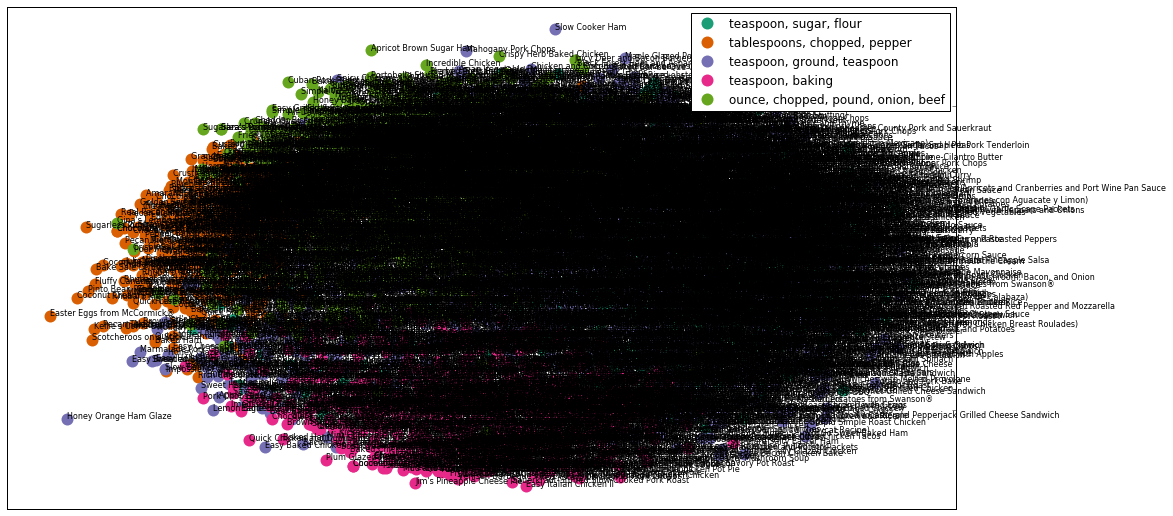

In [135]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [136]:
plt.close()

In [96]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [151]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
#     points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
#                      label=cluster_names[name], mec='none', 
#                      color=cluster_colors[name])
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=5, 
                     mec='none')
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

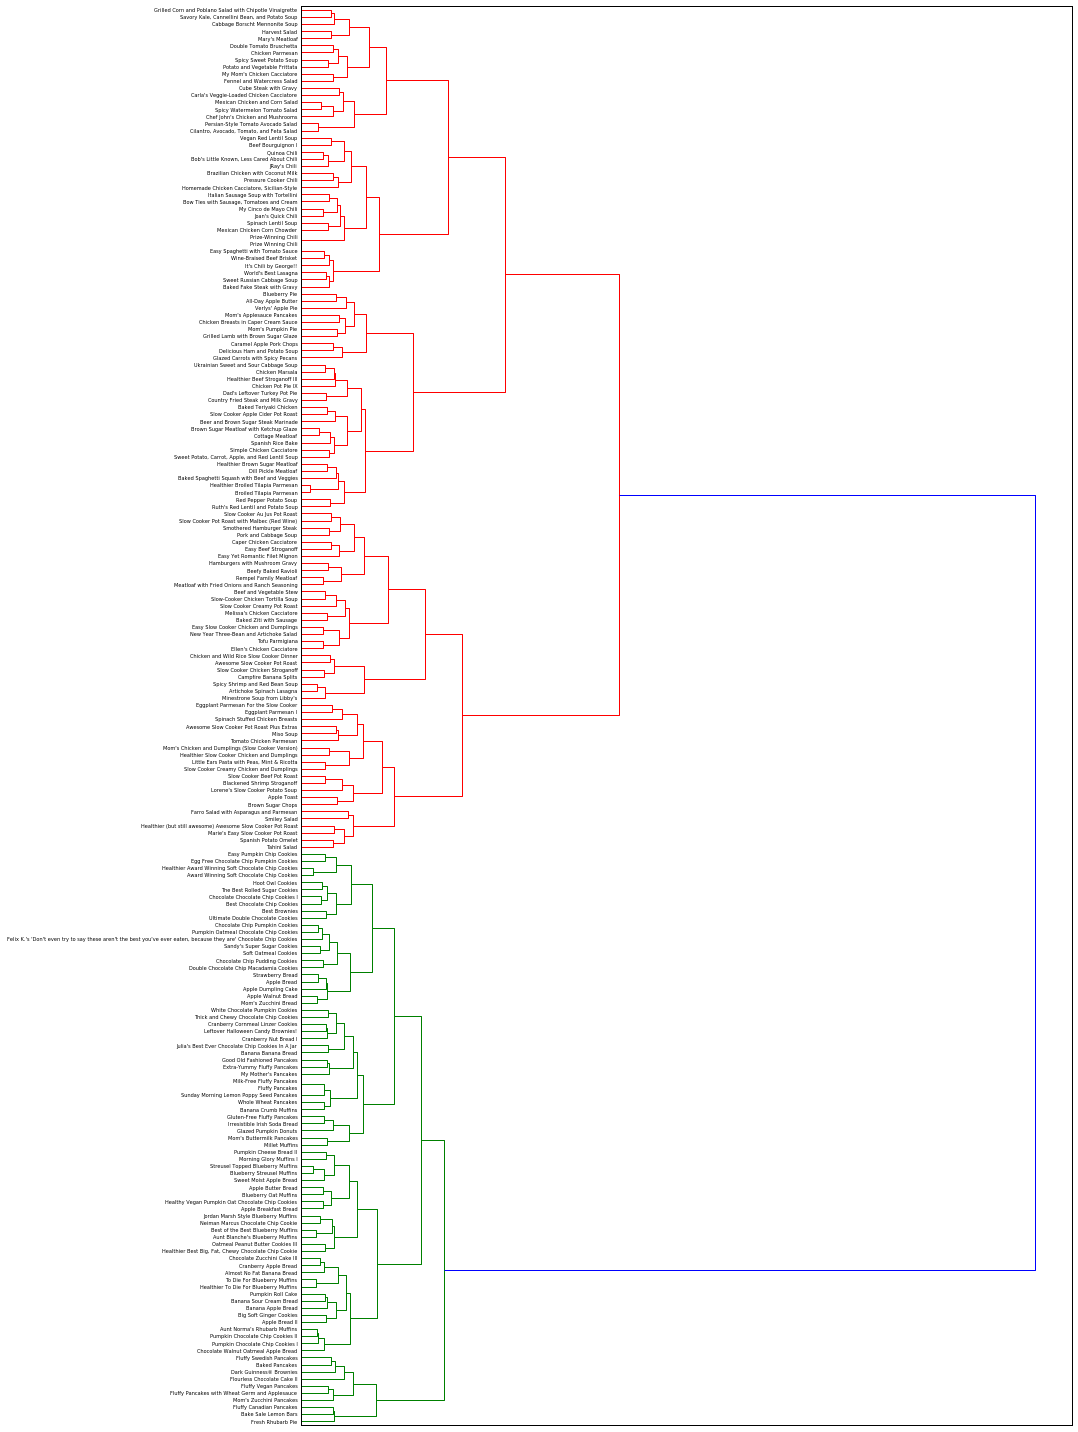

In [98]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [99]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [100]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [102]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

/home/andylane/anaconda2/envs/insight/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 80.9 ms
CPU times: user 208 ms, sys: 8 ms, total: 216 ms
Wall time: 208 ms
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 36.8 ms


In [103]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [105]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 30.9 s, sys: 0 ns, total: 30.9 s
Wall time: 30.9 s


In [106]:
lda.show_topics()

[(0,
  u"0.035*egg + 0.034*ketchup + 0.030*u'3/4 + 0.030*ounc + 0.028*mix + 0.024*brown + 0.023*packag + 0.023*instant + 0.020*beef + 0.018*beaten"),
 (1,
  u"0.117*teaspoon + 0.056*u'1/2 + 0.055*ground + 0.042*u'1/4 + 0.035*pepper + 0.030*chop + 0.028*salt + 0.022*tablespoon + 0.020*black + 0.017*powder"),
 (2,
  u"0.053*ounc + 0.044*tablespoon + 0.028*u'1/2 + 0.025*tast + 0.024*slice + 0.024*chicken + 0.021*pound + 0.021*onion + 0.020*pepper + 0.018*chees"),
 (3,
  u"0.062*chop + 0.044*ounc + 0.037*tomato + 0.032*tablespoon + 0.028*fresh + 0.026*pepper + 0.022*u'3 + 0.022*garlic + 0.020*onion + 0.019*clove"),
 (4,
  u"0.108*teaspoon + 0.059*u'1/2 + 0.049*sugar + 0.045*flour + 0.042*bake + 0.042*all-purpos + 0.039*white + 0.039*tablespoon + 0.035*egg + 0.030*butter")]

In [107]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

ValueError: setting an array element with a sequence

In [108]:
topics_matrix

[(0,
  [(u'egg', 0.034966204854007532),
   (u'ketchup', 0.033618578382231257),
   (u"u'3/4", 0.029896713660743264),
   (u'ounc', 0.029506366455990585),
   (u'mix', 0.028026908126588986),
   (u'brown', 0.024336227861476597),
   (u'packag', 0.023055975671479986),
   (u'instant', 0.022657843757045486),
   (u'beef', 0.020080948274695521),
   (u'beaten', 0.018458002270715979),
   (u'bread', 0.017503353972684245),
   (u'pound', 0.016964122836007307),
   (u'pud', 0.015348534267025184),
   (u'chocol', 0.015062009626139773),
   (u'pack', 0.014895506574648843),
   (u'crush', 0.014748732956628076),
   (u'dri', 0.013831205568807559),
   (u"u'1/4", 0.013290633840371237),
   (u'lean', 0.013112173353428458),
   (u'semisweet', 0.013018762687065488)]),
 (1,
  [(u'teaspoon', 0.11746819402085809),
   (u"u'1/2", 0.055821848563613691),
   (u'ground', 0.054794512089422098),
   (u"u'1/4", 0.042484062994221521),
   (u'pepper', 0.034961127683961105),
   (u'chop', 0.030255484982306634),
   (u'salt', 0.027631937

### Get names of recipes and cluster them: